In [4]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.lk04 import h, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Leak

import jaxley as jx
from jaxley import Compartment


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
class Compartment(Compartment):
    """
    Extend the Compartment class to include a voltage clamp method.
    """

    def voltage_clamp(
        self, V_hold1: float, V_step: float, T_hold1: int, T_step: int, dt: float,
        V_hold2: Optional[float] = None, T_hold2: Optional[int] = None,
        init_params = None
    ) -> Tuple[
        Dict[str, jnp.ndarray], Dict[str, Dict[str, jnp.ndarray]]
    ]:
        """
        Apply a voltage clamp to the Compartment and record the resulting currents and state changes.

        Args:
            V_hold1: The first holding voltage in mV.
            V_step: The step voltage in mV.
            T_hold1: The duration of the first holding voltage in time steps.
            T_step: The duration of the step voltage in time steps.
            dt: The time step in ms.
            V_hold2: The second holding voltage in mV (optional, defaults to V_hold1).
            T_hold2: The duration of the second holding voltage in time steps (optional, defaults to T_hold1).

        Returns:
            A tuple containing a dictionary for the currents and a dictionary for the state histories.
        """
        if V_hold2 is None:
            V_hold2 = V_hold1
        if T_hold2 is None:
            T_hold2 = T_hold1

        # Initialize the global state and dictionaries for currents and states
        params = {}
        states = {}
        channel_currents = {
            "hold1": {channel._name: [] for channel in self.channels},
            "step": {channel._name: [] for channel in self.channels},
            "hold2": {channel._name: [] for channel in self.channels},
        }
        channel_states_history = {
            "hold1": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "step": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "hold2": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
        }

        for channel in self.channels:
            states.update(channel.channel_states)
            params.update(channel.channel_params)

        if init_params is not None:
            params.update(init_params)
        
        # self.to_jax()

        def update_all_channels(V, dt, phase, states):
            for channel in self.channels:
                # Compute and store the current for the channel
                current = channel.compute_current(states, V, params)
                states[f"i{channel._name}"] = current
                channel_currents[phase][channel._name].append(current)

                # Update the states
                new_states = channel.update_states(states, dt, V, params)
                states.update(new_states)
                for state_key, state_value in new_states.items():
                    channel_states_history[phase][channel._name][state_key].append(state_value)

            return states

        # First hold phase
        for _ in range(T_hold1):
            states = update_all_channels(V_hold1, dt, "hold1", states)

        # Step phase
        for _ in range(T_step):
            states = update_all_channels(V_step, dt, "step", states)

        # Second hold phase
        for _ in range(T_hold2):
            states = update_all_channels(V_hold2, dt, "hold2", states)

        # Convert lists to jnp.ndarray and merge all phases
        merged_currents = {}
        for channel_name in channel_currents["hold1"]:
            merged_currents[channel_name] = jnp.concatenate([
                jnp.array(channel_currents["hold1"][channel_name]),
                jnp.array(channel_currents["step"][channel_name]),
                jnp.array(channel_currents["hold2"][channel_name])
            ])

        merged_states_history = {}
        for channel_name in channel_states_history["hold1"]:
            merged_states_history[channel_name] = {}
            for state_name in channel_states_history["hold1"][channel_name]:
                merged_states_history[channel_name][state_name] = jnp.concatenate([
                    jnp.array(channel_states_history["hold1"][channel_name][state_name]),
                    jnp.array(channel_states_history["step"][channel_name][state_name]),
                    jnp.array(channel_states_history["hold2"][channel_name][state_name])
                ])

        return merged_currents, merged_states_history


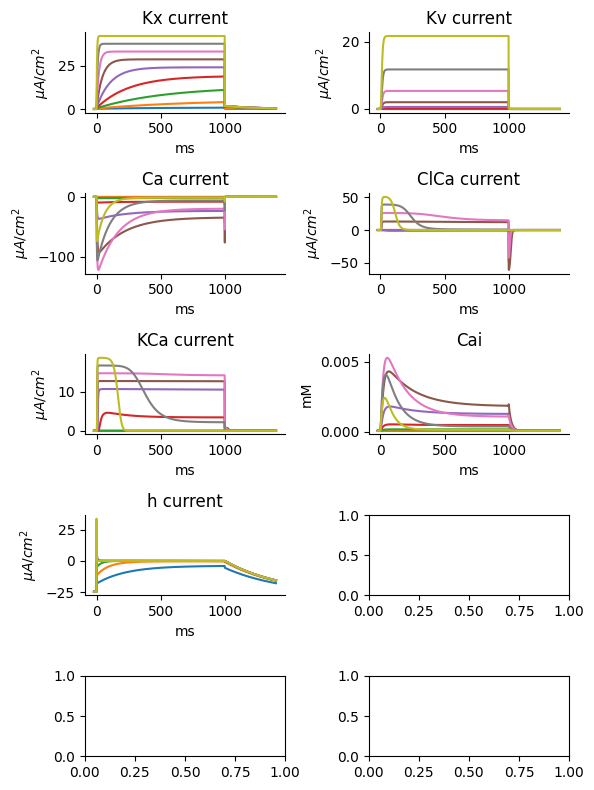

In [6]:
cell = Compartment()

cell.insert(Kx())
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
# cell.insert(CaNernstReversal())
# The original code didn't allow eCa to be updated 
cell.insert(h())
cell.insert(Leak())

params = {
    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.332e-3,

    "Ca_gCa": 4e-3,
    "eCa": 40,
    
    "Kv_gKv": 1e-3,
    "h_gh": 2.5e-3,
    "h_eh": -32,
    "Kx_gKx": 0.45e-3,
    "eK": -74,
    "v": -34,
}

dt = 1 # ms    
V_hold = -70.0  # mV, the holding potential
T_hold = int(1000 / dt) # 300 ms
T_step = int(1000 / dt) # 300 ms


fig, ax = plt.subplots(4, 2, figsize=(6,8))
ax = ax.flatten()


# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 20  # ms
post_step_duration = 400  # ms

pre_step_indices = pre_step_duration // dt
post_step_indices = post_step_duration // dt

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices


# Create the time axis
time_window = jnp.arange(-pre_step_duration, T_step + post_step_duration, dt)

steady_state_currents_900 = []
steady_state_currents_1020 = []
V_steps = jnp.arange(-60, 21, 10)
for V_step in V_steps:
    currents, states = cell.voltage_clamp(V_hold1=V_hold, V_step=V_step, T_hold1=T_hold, T_step=T_step, dt=dt, init_params=params)
    ax = ax.flatten()
    for i, key in enumerate(currents):
        if key == "CaPump":
            ax[i].plot(time_window, states["CaPump"]["Cai"][start_step_index:end_step_index], label=f"V={V_step}")
            ax[i].set_title("Cai")
            ax[i].set_ylabel("mM")
        elif key == "CaNernstReversal":
            ax[i].axis("off")
        else:
            if key == "Leak":
                continue
            ax[i].plot(time_window, currents[key][start_step_index:end_step_index], label=f"V={V_step}")
            ax[i].set_title(key + " current")
            ax[i].set_ylabel(r"$μA/cm^2$")

        ax[i].set_xlabel("ms")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)

fig.tight_layout()